In [32]:
#Import Modules
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from ModelBuild import buildModel
from ModelBuild import ptetaphi2pxpypz
from ModelBuild import ptetaphi2pxpypz2
from TrackMatcher import matchTracks
from Plotting import binneddensity, fixedbinning
from ModelBuild import flatten1
#Set hyperparameters
MASKVAL = 0
MAXTRACKS = 32
BATCHSIZE = 64
EPOCHS = 200
MAXEVENTS = 99999999999999999
# VALFACTOR = 10
LR = 1e-15

#Open the root file
tree = uproot.open("hffrag.root:CharmAnalysis")

# Decide which branches of the tree we actually want to look at
  # True jet information
jetfeatures=["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi"]

# true b-hadron information
# these b-hadrons are inside the truth jets
bhadfeatures=["AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta", "AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
  
# reconstructed track information
trackfeatures=[ "AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]

# Read in the requested branches from the file
features = tree.arrays(jetfeatures + trackfeatures, entry_stop=MAXEVENTS)

#Data Processing
events = features[awkward.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

jets1 = events[jetfeatures][:,0] #First jet
tracks = events[trackfeatures]

matchedtracks = tracks[matchTracks(jets1, tracks)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS) #Turn into regular np array

bjets = awkward.sum(jets1["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0 #Find b hadron jets with certain momentum
jets2 = jets1[bjets] #Jets identified as b jets are only jets considered
bhadspt= jets2["AnalysisAntiKt4TruthJets_ghostB_pt"][:,0] #np Stack here - Each sub array contains all the features of the jet (axis -1)
bhadseta = jets2["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0]
bhadsphi = jets2["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0]
matchedtracks = matchedtracks[bjets]

jets3 = structured_to_unstructured(jets2[jetfeatures[:-3]]) #number of features
matchedtracks = structured_to_unstructured(matchedtracks)

jets4 = ptetaphi2pxpypz(jets3).to_numpy()
tracks = ptetaphi2pxpypz2(matchedtracks.to_numpy())
tracks = np.concatenate([tracks, matchedtracks[:,:,3:].to_numpy()], axis = 2)
bhadspt = bhadspt.to_numpy()
bhadseta = bhadseta.to_numpy()
bhadsphi = bhadsphi.to_numpy()
bhads = np.stack([bhadspt, bhadseta], axis=-1)

tracklayers = [ 32 , 32 , 32 , 32 , 32 ]
jetlayers = [ 64 , 64 , 64 , 64 , 64 ]
trackfeatures =["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
model = buildModel([len(trackfeatures)] + tracklayers, jetlayers, 2)
model.load_weights("/home/physics/phuspv/.ssh/Project/Weights/15k Epochs.ckpt")

matchedtracks = matchedtracks.to_numpy()

#Convert bhads characteristics to cartesian
bhads2 = np.stack([bhadspt, bhadseta, bhadsphi], axis=-1)
bhadscart = ptetaphi2pxpypz(bhads2)

In [33]:
%matplotlib inline

In [34]:
X_train = np.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/X_train_data.npy")
X_valid = np.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/X_valid_data.npy")
y_train = np.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/y_train_data.npy")
y_valid = np.load("/home/physics/phuspv/.ssh/Project/TrainingAndValidationData/y_valid_data.npy")
pred = model.predict(tracks)
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

639/639 [==============================] - 1s 1ms/step


In [35]:
pTDiff=pred[:,0] - bhads[:,0]
pTErr= np.exp(pred[:,2])
pTPull = pTDiff/pTErr

etaDiff = pred[:,1] - bhads[:,1]
etaErr = np.exp(pred[:, 3])
etaPull = etaDiff/etaErr

In [36]:
#Creating data for polar plotting, masking out zeroes
trackpT = np.sum(matchedtracks[:,:,0], axis = 1)
tracketa = np.sum(matchedtracks[:,:,1], axis = 1)
trackphi = np.sum(matchedtracks[:,:,2], axis = 1)
ptmasked_list = []
etamasked_list = []
phimasked_list = []

for x in range(len(trackpT)):
    pTmask = (trackpT[x]!=0)
    ptmasked_list.append(pTmask)
    etamask = (tracketa[x]!=0)
    etamasked_list.append(etamask)
    phimask = (trackphi[x]!=0)
    phimasked_list.append(phimask)
trackpT = trackpT[ptmasked_list]
tracketa = tracketa[etamasked_list]
trackphi = trackphi[phimasked_list]

bhadspt = bhads2[:,0]
bhadseta = bhads2[:,1]
bhadsphi = bhads2[:,2]

bhadspt = bhadspt[ptmasked_list]   
bhadseta = bhadseta[etamasked_list]
bhadsphi = bhadsphi[phimasked_list]

ptprop = trackpT/bhadspt

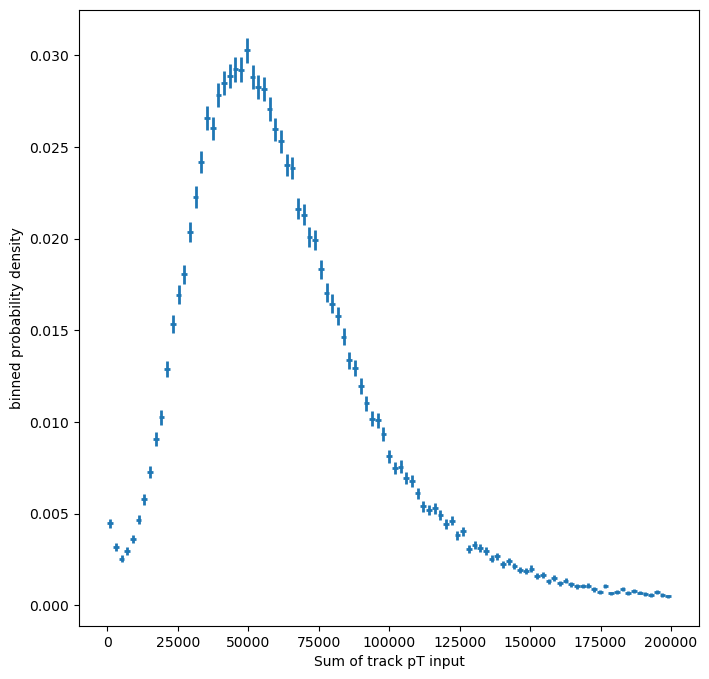

In [37]:
#Plot the sum of pTs input into model
fig = binneddensity(trackpT, fixedbinning(00000, 200000, 100), xlabel = 'Sum of track pT input')
fig

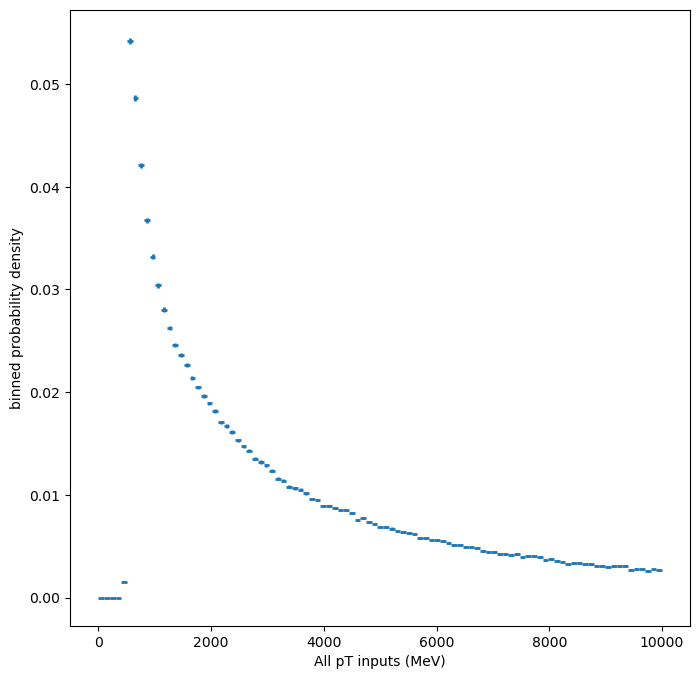

In [38]:
#Plot every track pT input into model
fig = binneddensity(matchedtracks[:,:,0], fixedbinning(0.00001,10000,100), xlabel = 'All pT inputs (MeV)')
fig

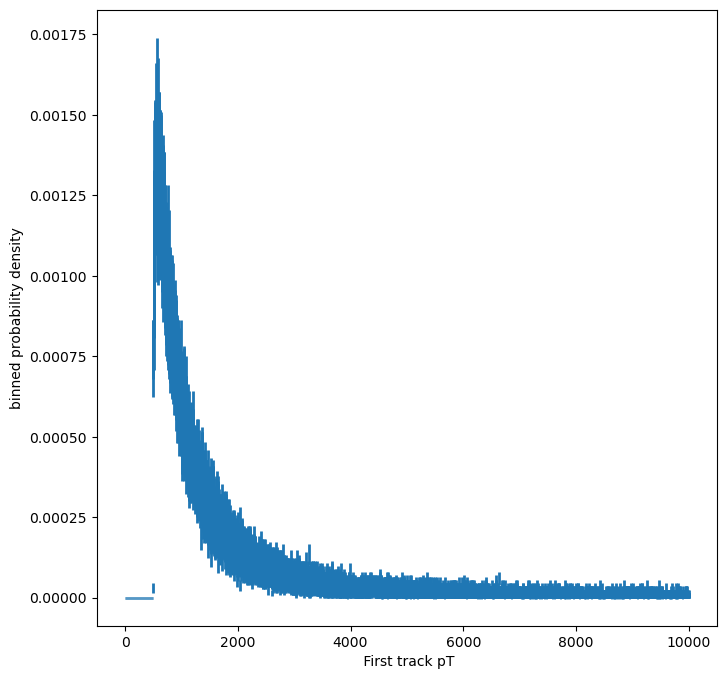

In [39]:
#Plot first track pT values
fig = binneddensity(features["AnalysisTracks_pt"][:,0],fixedbinning(0,10000,10000),xlabel = " First track pT")
fig

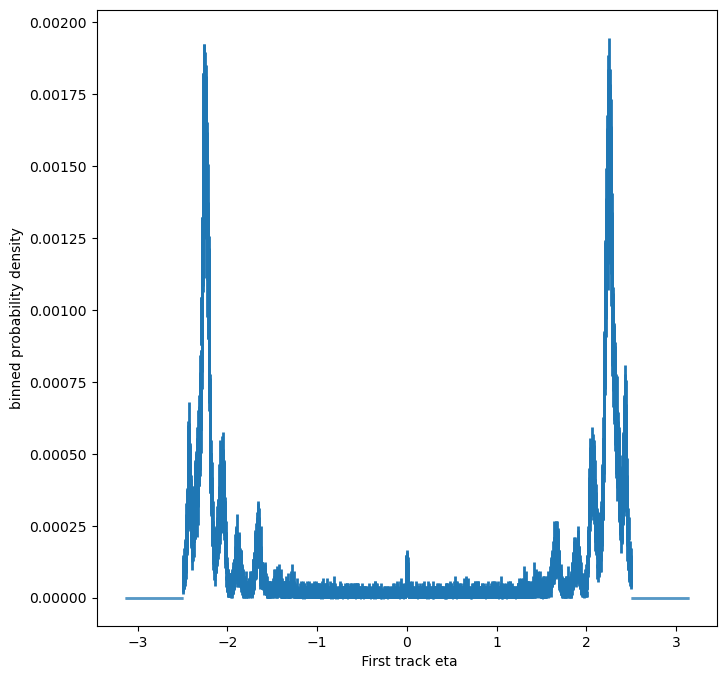

In [40]:
#Plot first track eta values
fig = binneddensity(features["AnalysisTracks_eta"][:,0],fixedbinning(-np.pi,np.pi,10000),xlabel = " First track eta")
fig

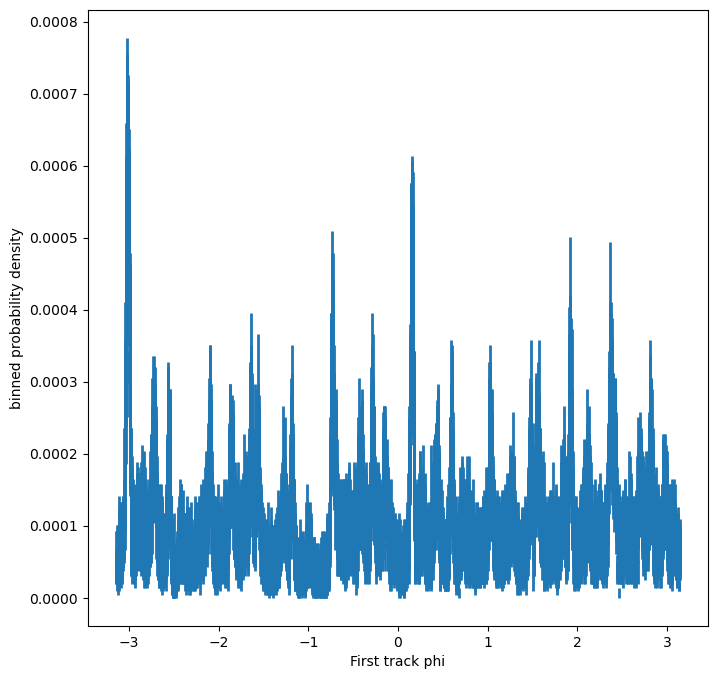

In [41]:
#Plot first track phi values
fig = binneddensity(features["AnalysisTracks_phi"][:,0],fixedbinning(-np.pi,np.pi,10000),xlabel = "First track phi")
fig

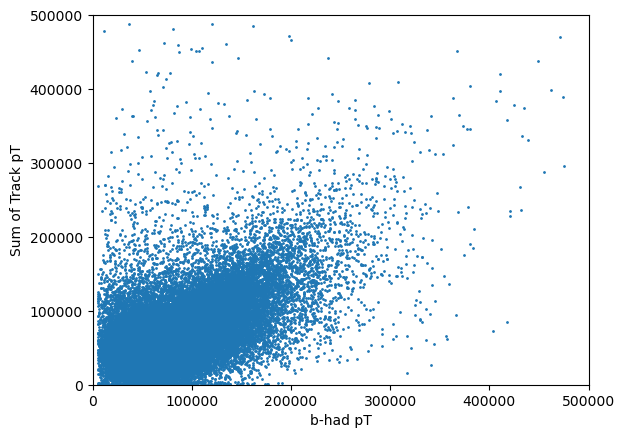

In [42]:
# Creating plot of b hadron pT vs sum of track pT
plt.scatter(bhadspt, trackpT, s=1)
plt.xlabel('b-had pT')
plt.ylabel('Sum of Track pT')
plt.xlim([0,500000])
plt.ylim(([0, 500000]))
# show plot
plt.show()


In [43]:
#Creating data for cartesian plotting, masking out zeroes
trackpx = np.sum(tracks[:,:,0], axis = 1)
trackpy = np.sum(tracks[:,:,1], axis = 1)
trackpz = np.sum(tracks[:,:,2], axis = 1)
pxmasked_list = []
pymasked_list = []
pzmasked_list = []

for x in range(len(trackpx)):
    pxmask = (trackpx[x]!=0)
    pxmasked_list.append(pxmask)
    pymask = (trackpy[x]!=0)
    pymasked_list.append(pymask)
    pzmask = (trackpz[x]!=0)
    pzmasked_list.append(pzmask)
trackpx = trackpx[pxmasked_list]
trackpy = trackpy[pymasked_list]
trackpz = trackpz[pzmasked_list]

bhadspx = bhadscart[:,0]
bhadspy = bhadscart[:,1]
bhadspz = bhadscart[:,2]

bhadspx = bhadspx[pxmasked_list]   
bhadspy = bhadspy[pymasked_list]
bhadspz = bhadspz[pzmasked_list]

pxprop = trackpx/bhadspx
pyprop = trackpy/bhadspy
pzprop = trackpz/bhadspz


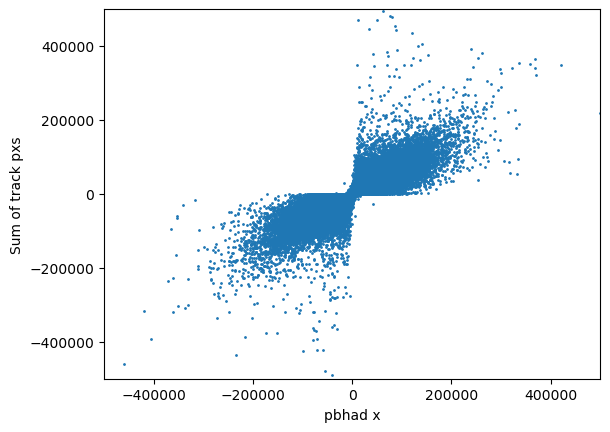

In [44]:
# Creating plot of bhads px vs sum of track px
plt.scatter(bhadspx, trackpx, s=1)
plt.xlabel('pbhad x')
plt.ylabel('Sum of track pxs')
plt.xlim([-500000, 500000])
plt.ylim(([-500000, 500000]))
plt.show()

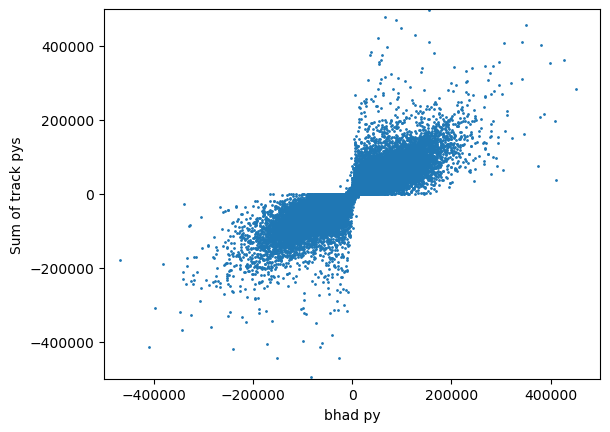

In [45]:
# Creating plot of bhads py vs sum of track py
plt.scatter(bhadspy, trackpy, s=1)
plt.xlabel('bhad py')
plt.ylabel('Sum of track pys')
plt.xlim([-500000, 500000])
plt.ylim(-500000,500000)
plt.show()

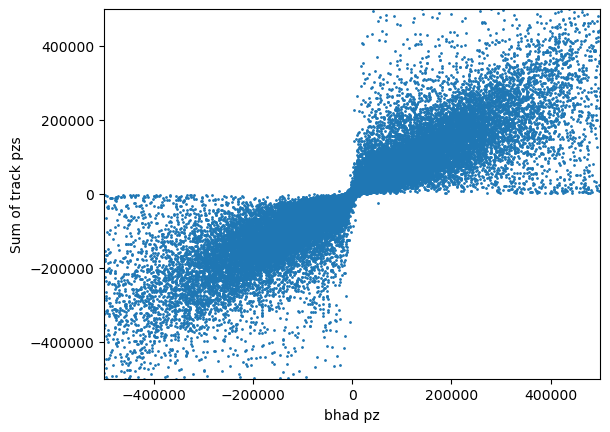

In [46]:
# Creating plot of bhads pz vs sum of track pz
plt.scatter(bhadspz, trackpz, s=1)
plt.xlabel('bhad pz')
plt.ylabel('Sum of track pzs')
plt.xlim([-500000, 500000])
plt.ylim(-500000,500000)
plt.show()

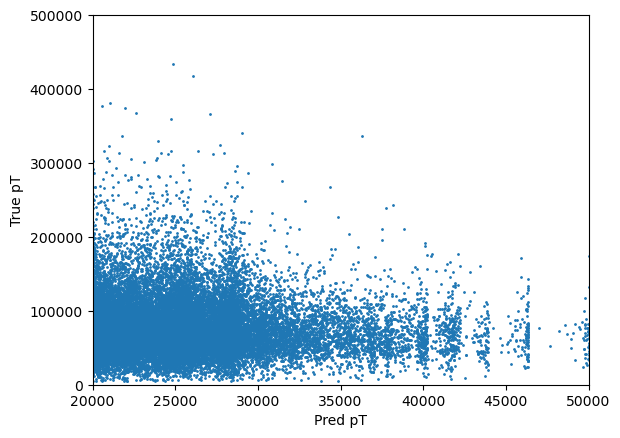

In [47]:

plt.scatter(pred[:,0], bhads[:,0], s=1)
plt.xlabel('Pred pT')
plt.ylabel('True pT')
plt.xlim([20000, 50000])
plt.ylim(0,500000)
plt.show()

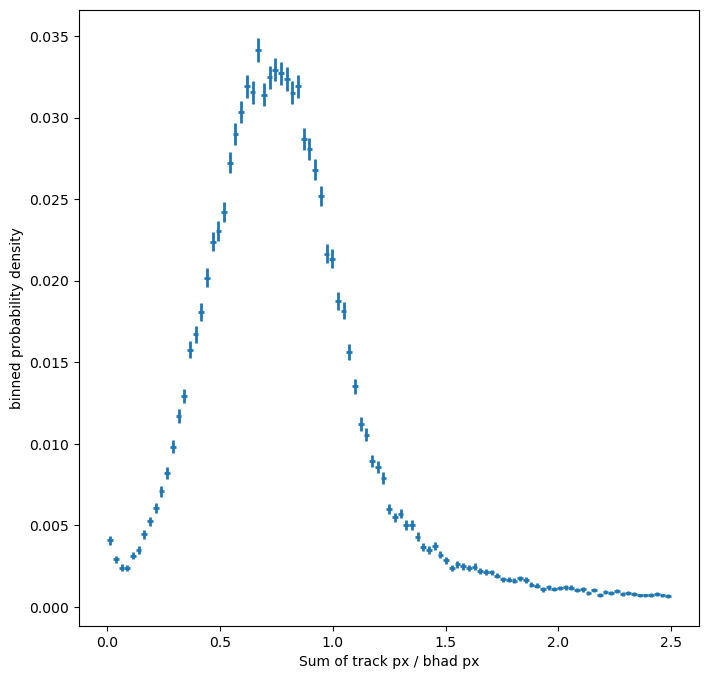

In [48]:
#Plotting proportion of bhad px detected in tracks
fig = binneddensity(pxprop, fixedbinning(0,2.5,100) ,xlabel = 'Sum of track px / bhad px')
fig

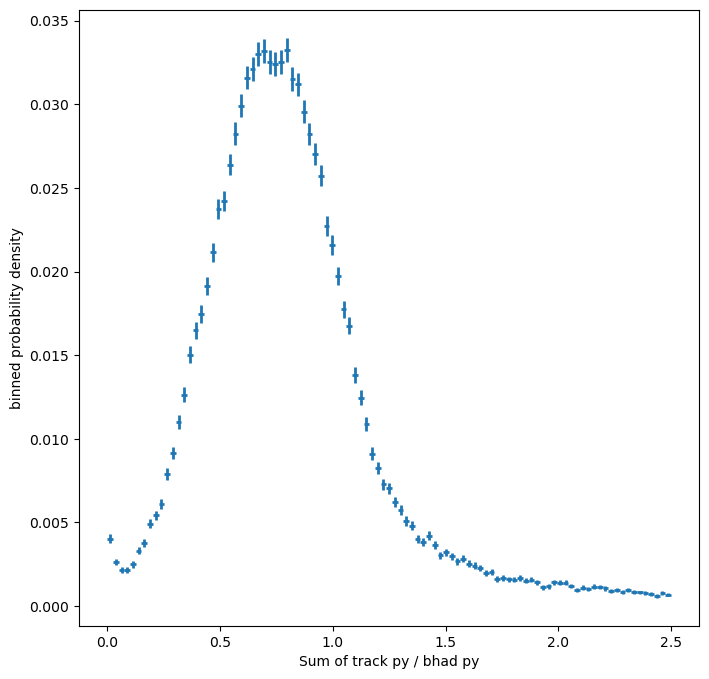

In [49]:
#Plotting proportion of bhad py detected in tracks
fig = binneddensity(pyprop, fixedbinning(0,2.5,100) ,xlabel = 'Sum of track py / bhad py')
fig

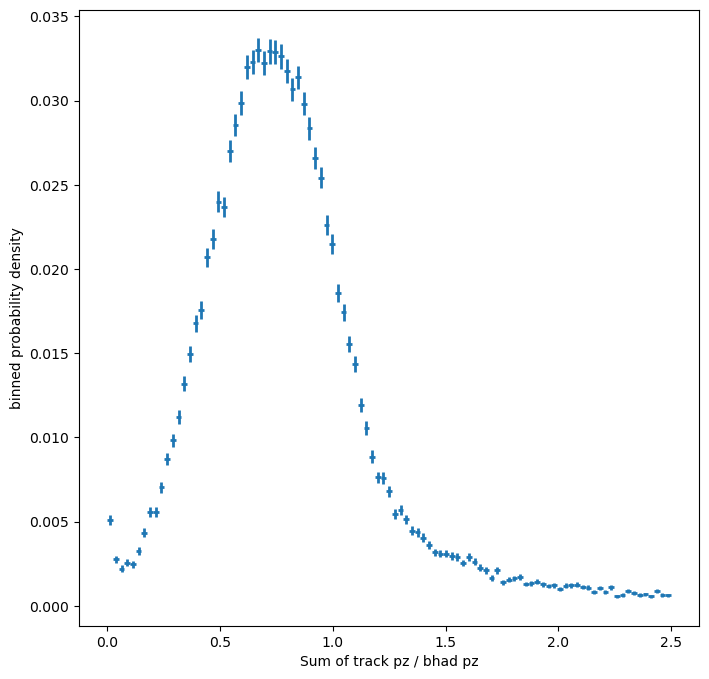

In [50]:
#Plotting proportion of bhad pz detected in tracks
fig = binneddensity(pzprop, fixedbinning(0,2.5,100) ,xlabel = 'Sum of track pz / bhad pz')
fig

/home/physics/phuspv/.ssh/Project/Plotting.py:28: RuntimeWarning: invalid value encountered in true_divide
  ys = ys / s
/home/physics/phuspv/.ssh/Project/Plotting.py:29: RuntimeWarning: invalid value encountered in true_divide
  yerrs = yerrs / s
/home/physics/phuspv/anaconda3/envs/Luke/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


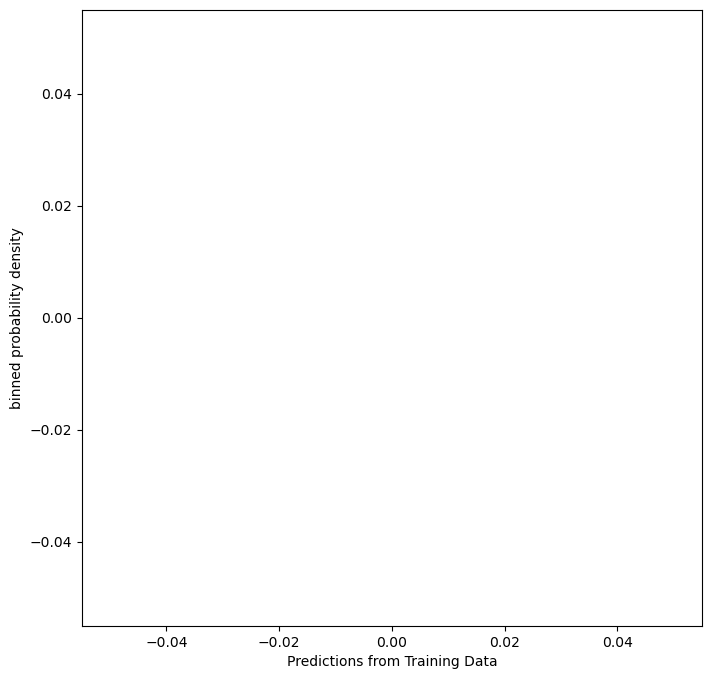

In [51]:
#Plotting the predictions from training data
trainfig=binneddensity(train_pred[:,0], fixedbinning(70, 100, 100), xlabel="Predictions from Training Data")
trainfig

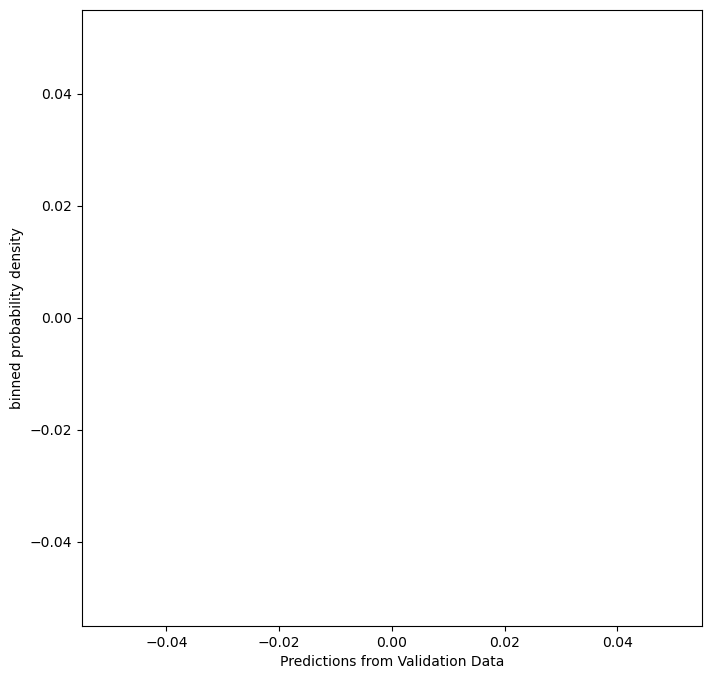

In [52]:
#Plotting the predictions from the validation data
valfig=binneddensity(valid_pred[:,0], fixedbinning(70, 100, 100), xlabel="Predictions from Validation Data")
valfig

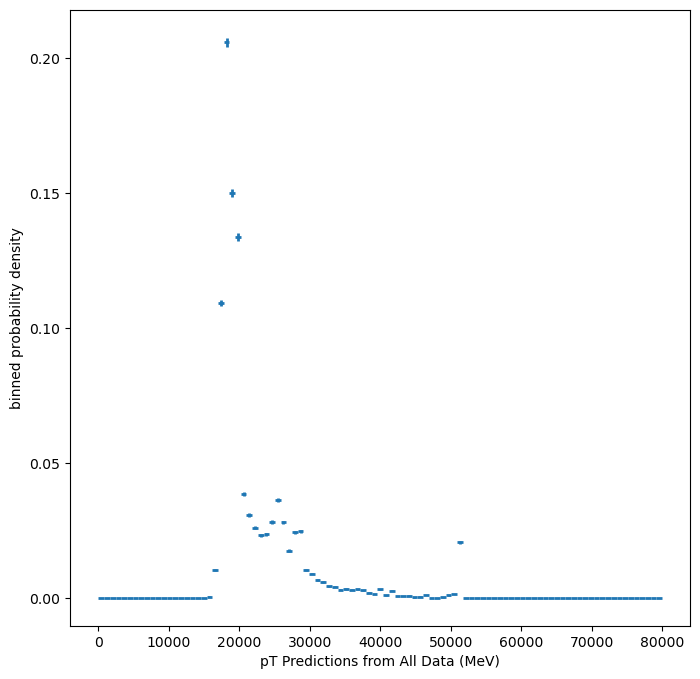

In [53]:
#Plotting the overall predictions
fig=binneddensity(pred[:,0], fixedbinning(0000, 80000, 100), xlabel="pT Predictions from All Data (MeV)")
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/Predictions.png")
fig

In [54]:
print(np.mean(pred[:,0]))
print(np.std(pred[:,0]))

22110.53
6484.614


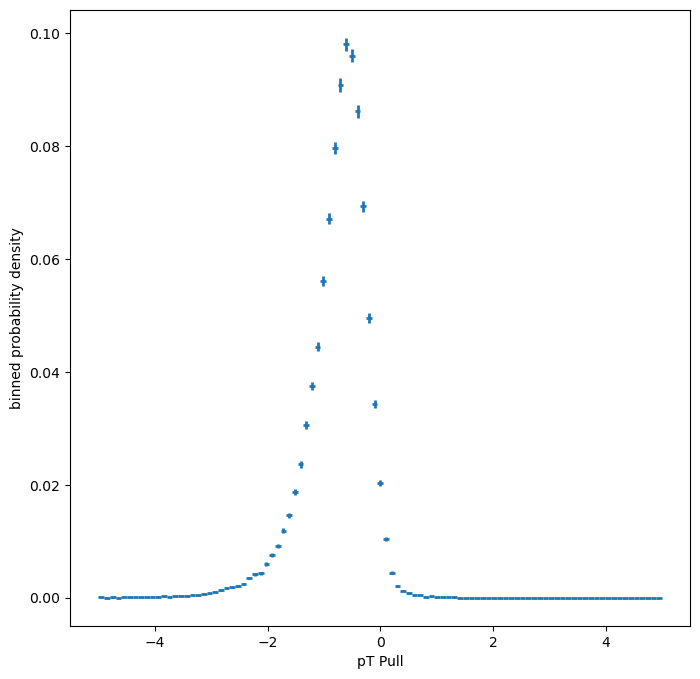

In [55]:
#Plotting and saving the pT pull
fig=binneddensity(pTPull,fixedbinning(-5, 5, 100), xlabel="pT Pull")
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/pT Pull 5k.png")
fig

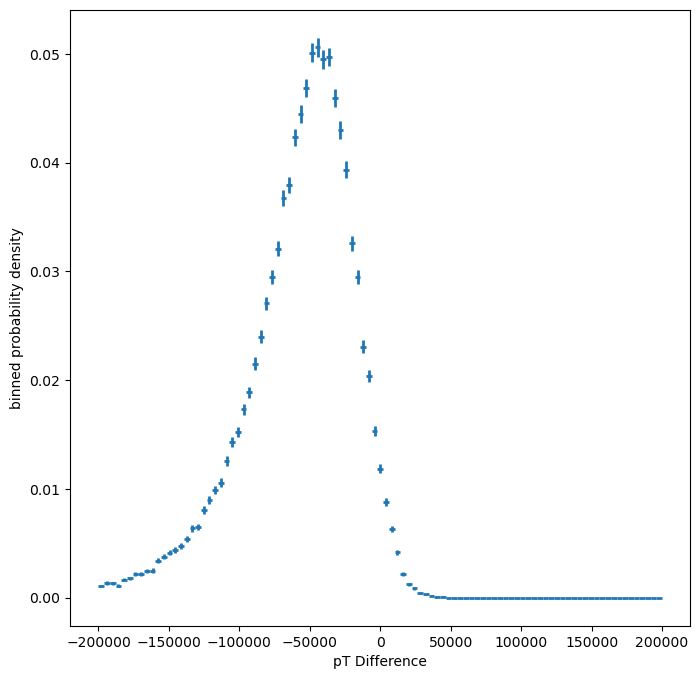

In [56]:
fig = \
binneddensity \
( pTDiff
, fixedbinning(-200000, 200000, 100)
, xlabel="pT Difference"
)
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/pT Difference 5k.png")
fig

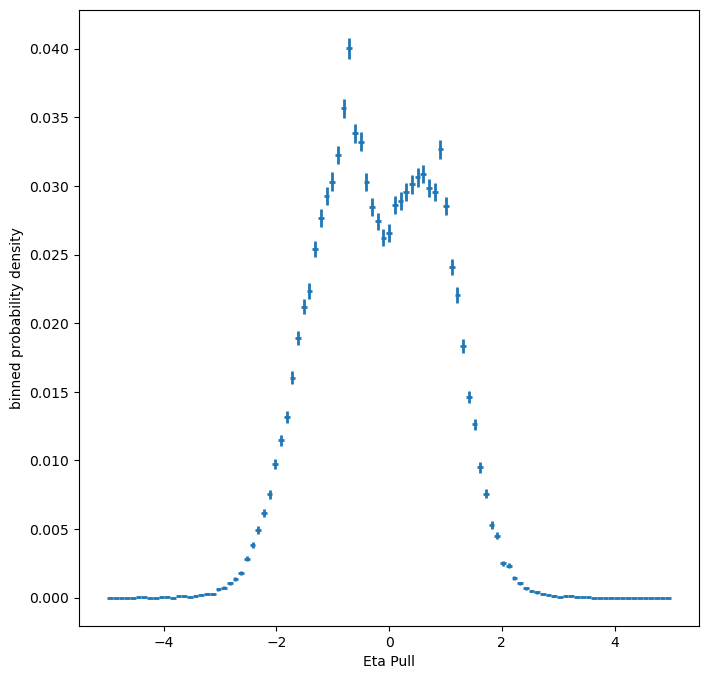

In [57]:
#Plotting and saving the pT pull
fig=binneddensity(etaPull,fixedbinning(-5, 5, 100), xlabel="Eta Pull")
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/eta Pull.png")
fig

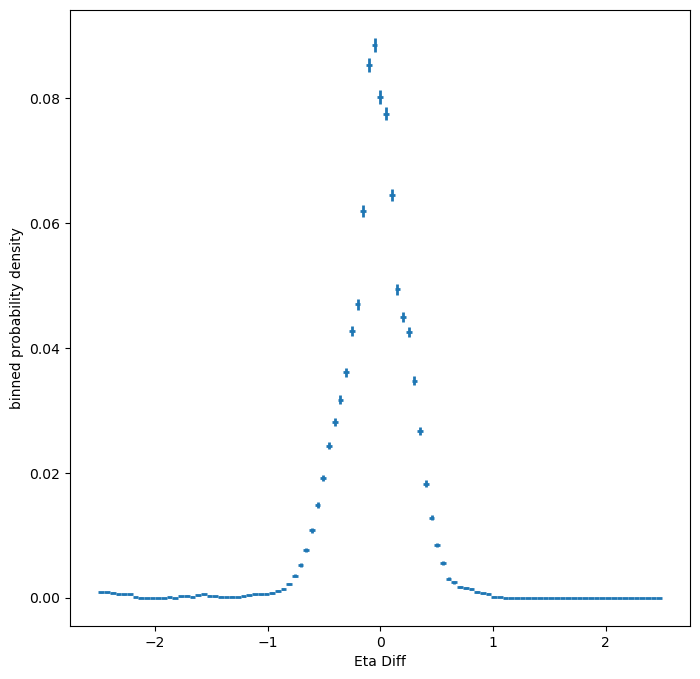

In [58]:
#Plotting and saving the pT pull
fig=binneddensity(etaDiff,fixedbinning(-2.5, 2.5, 100), xlabel="Eta Diff")
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/eta Pull.png")
fig

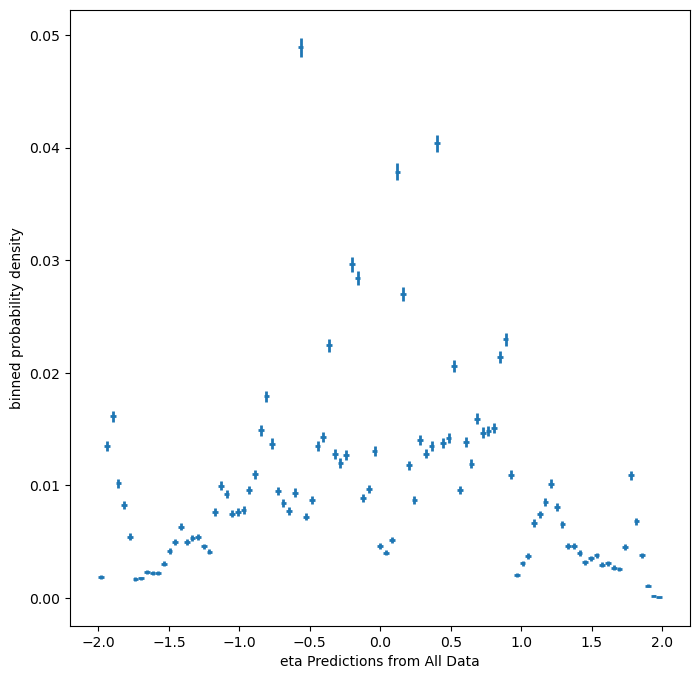

In [59]:
#Plotting the overall predictions
fig=binneddensity(pred[:,1], fixedbinning(-2, 2, 100), xlabel="eta Predictions from All Data")
#fig.savefig("/home/physics/phuspv/.ssh/Project/Plots/eta Predictions.png")
fig

In [60]:
epochtimes = np.load('/home/physics/phuspv/.ssh/Project/Epoch Times/15k Epoch Times.npy')
print(np.mean(epochtimes))
print(len(epochtimes))

5.755783754698435
15000


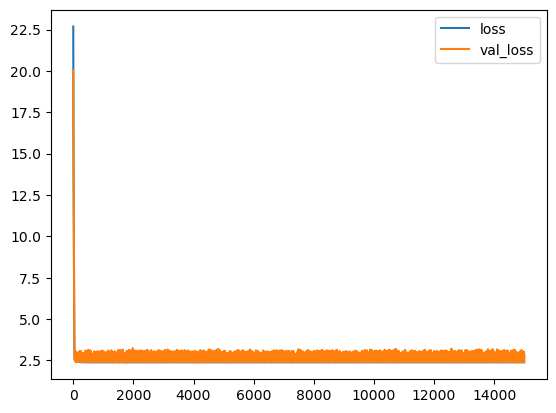

In [66]:
lossdata = pd.read_pickle('/home/physics/phuspv/.ssh/Project/Loss Data/15k Epochs.pkl')

LossFigure = lossdata.loc[:, ['loss', 'val_loss']].plot().get_figure()